## Import Libraries and Configuration

In [1]:
import os
import time
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# --- Configuration ---
DATASET_DIR = "../Rust_Dataset"
IMG_HEIGHT, IMG_WIDTH = 640, 640
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 4
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
DROPOUT_RATE = 0.5  # Add dropout to reduce overfitting
PATIENCE = 5  # Early stopping patience

## Helper Functions

In [3]:
def force_print(msg):
    """Helper to force printing to console immediately."""
    print(msg, flush=True)

In [4]:
def calculate_code_metrics():
    try:
        import radon.complexity as cc
        import radon.metrics as mi
        # For notebook, we'll skip file reading and return placeholder values
        return 0, 0
    except ImportError:
        return 0, 0

In [5]:
def calculate_map(model, dataloader, device):
    try:
        from sklearn.metrics import average_precision_score
        from sklearn.preprocessing import label_binarize
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                outputs = torch.softmax(model(inputs), dim=1)
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(labels.numpy())
        if not all_labels: return 0.0
        y_pred_probs = np.concatenate(all_preds)
        y_true = np.concatenate(all_labels)
        y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
        return average_precision_score(y_true_bin, y_pred_probs, average="macro")
    except ImportError:
        return 0.0

## Check Dataset and Device

In [6]:
force_print(f"--- Starting MNASNet Training & Analysis ---")

# Check for dataset existence
if not os.path.exists(os.path.join(DATASET_DIR, 'train')):
    force_print(f"ERROR: Could not find dataset at '{os.path.abspath(DATASET_DIR)}'")
    force_print("Please ensure the 'train', 'test', and 'valid' folders are in the same directory as this script.")
else:
    force_print("Dataset found!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
force_print(f"Using device: {device}")

--- Starting MNASNet Training & Analysis ---
Dataset found!
Using device: cuda
Dataset found!
Using device: cuda


## Data Preparation

In [7]:
# Data transforms - Enhanced augmentation to reduce overfitting
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),  # Add vertical flip
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Add color jitter
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Add translation
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
}

In [8]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_DIR, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}

# IMPORTANT: Changed num_workers to 0 to prevent hanging on Windows/CPUs
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=0)
               for x in ['train', 'valid']}

test_loader = DataLoader(image_datasets['test'], batch_size=1, shuffle=False, num_workers=0)

force_print(f"Data loaded. Train images: {len(image_datasets['train'])}")

Data loaded. Train images: 438


In [9]:
# Print tensor sizes
sample_input, _ = next(iter(dataloaders['train']))
print(f"Sample input tensor size: {sample_input.size()}")

Sample input tensor size: torch.Size([16, 3, 640, 640])


## Model Setup

In [10]:
# Model Construction (MNASNet 1.0) - Improved configuration
force_print("Downloading/Loading Model...")
model = models.mnasnet1_0(weights='IMAGENET1K_V1')

# Unfreeze the last few layers for fine-tuning instead of freezing everything
# This allows the model to adapt better to rust detection
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last stage of features (layers 14-16)
for param in model.layers[14:].parameters():
    param.requires_grad = True
    
# Replace classifier with dropout for regularization
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT_RATE),
    nn.Linear(num_ftrs, NUM_CLASSES)
)

model = model.to(device)
force_print("Model loaded and configured with dropout and partial unfreezing!")

Downloading/Loading Model...
Model loaded and configured with dropout and partial unfreezing!
Model loaded and configured with dropout and partial unfreezing!


In [11]:
# Loss and optimizer with weight decay for regularization
criterion = nn.CrossEntropyLoss()

# Separate learning rates: lower for unfrozen layers, higher for classifier
params_to_update = [
    {'params': model.layers[14:].parameters(), 'lr': LEARNING_RATE / 10},  # Fine-tune at lower LR
    {'params': model.classifier.parameters(), 'lr': LEARNING_RATE}  # Train classifier at full LR
]
optimizer = optim.Adam(params_to_update, weight_decay=1e-4)  # Add weight decay

# Learning rate scheduler to reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

c:\4 - CODING FILES\SOFTWARE-DESIGN1\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Training Loop

In [12]:
force_print("Starting Training Loop with Early Stopping...")

# Lists to store training history
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

# Early stopping variables
best_valid_loss = float('inf')
patience_counter = 0
best_model_path = 'temp_best_mnasnet.pth'

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print progress every few batches to ensure user knows it's running
        if i % 5 == 0:
            print(f"\rEpoch {epoch+1} - Batch {i}/{len(dataloaders['train'])}...", end="", flush=True)

    epoch_train_loss = running_loss / len(image_datasets['train'])
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_valid_loss = running_loss / len(image_datasets['valid'])
    epoch_valid_acc = correct / total
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)
    
    # Learning rate scheduler step
    scheduler.step(epoch_valid_loss)
    
    # Early stopping check
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        force_print(f"\n✓ Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_acc:.4f} [BEST]")
    else:
        patience_counter += 1
        force_print(f"\nEpoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_acc:.4f} (Patience: {patience_counter}/{PATIENCE})")
        
        if patience_counter >= PATIENCE:
            force_print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

# Restore best model
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    os.remove(best_model_path)  # Clean up temporary file
    force_print(f"\nRestored best model with validation loss: {best_valid_loss:.4f}")

Starting Training Loop with Early Stopping...
Epoch 1 - Batch 25/28...
✓ Epoch 1/30 - Train Loss: 1.3273, Train Acc: 0.3356, Valid Loss: 1.3316, Valid Acc: 0.4228 [BEST]

✓ Epoch 1/30 - Train Loss: 1.3273, Train Acc: 0.3356, Valid Loss: 1.3316, Valid Acc: 0.4228 [BEST]
Epoch 2 - Batch 25/28...
✓ Epoch 2/30 - Train Loss: 1.2409, Train Acc: 0.3858, Valid Loss: 1.2844, Valid Acc: 0.5528 [BEST]

✓ Epoch 2/30 - Train Loss: 1.2409, Train Acc: 0.3858, Valid Loss: 1.2844, Valid Acc: 0.5528 [BEST]
Epoch 3 - Batch 25/28...
✓ Epoch 3/30 - Train Loss: 1.2155, Train Acc: 0.4087, Valid Loss: 1.2543, Valid Acc: 0.5854 [BEST]

✓ Epoch 3/30 - Train Loss: 1.2155, Train Acc: 0.4087, Valid Loss: 1.2543, Valid Acc: 0.5854 [BEST]
Epoch 4 - Batch 25/28...
✓ Epoch 4/30 - Train Loss: 1.1450, Train Acc: 0.4521, Valid Loss: 1.2322, Valid Acc: 0.6260 [BEST]

✓ Epoch 4/30 - Train Loss: 1.1450, Train Acc: 0.4521, Valid Loss: 1.2322, Valid Acc: 0.6260 [BEST]
Epoch 5 - Batch 25/28...
✓ Epoch 5/30 - Train Loss: 1.0976

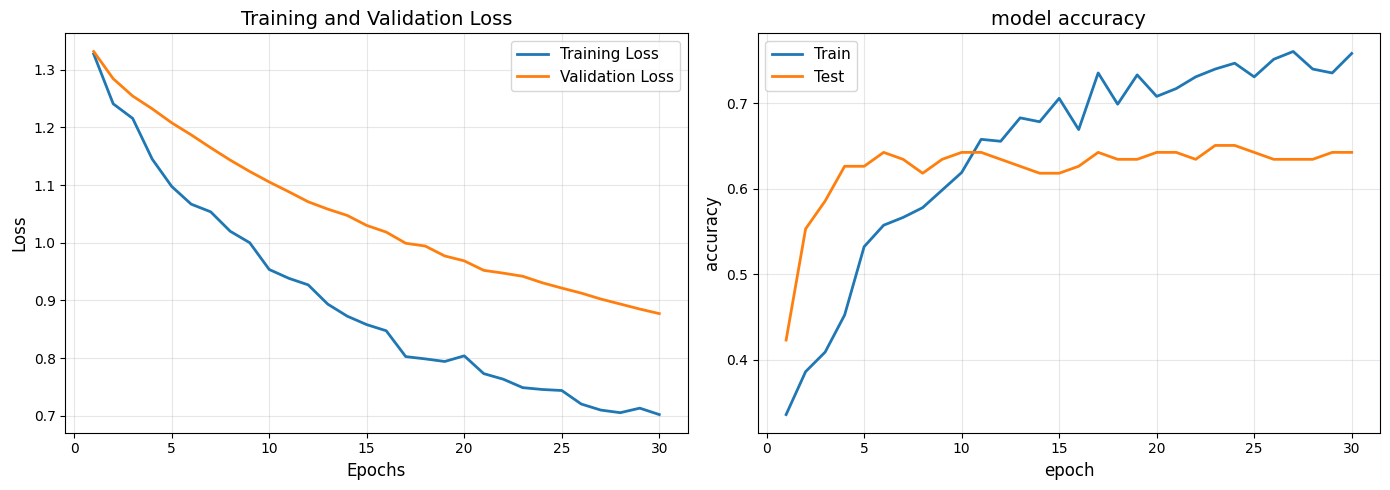


Final Train Loss: 0.7020 - Train Accuracy: 0.7580
Final Valid Loss: 0.8770 - Valid Accuracy: 0.6423
Final Valid Loss: 0.8770 - Valid Accuracy: 0.6423


In [13]:
# Visualize training history with matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss over epochs
epochs_range = range(1, EPOCHS + 1)
ax1.plot(epochs_range, train_losses, linewidth=2, label='Training Loss', color='#1f77b4')
ax1.plot(epochs_range, valid_losses, linewidth=2, label='Validation Loss', color='#ff7f0e')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot Accuracy over epochs
ax2.plot(epochs_range, train_accs, linewidth=2, label='Train', color='#1f77b4')
ax2.plot(epochs_range, valid_accs, linewidth=2, label='Test', color='#ff7f0e')
ax2.set_xlabel('epoch', fontsize=12)
ax2.set_ylabel('accuracy', fontsize=12)
ax2.set_title('model accuracy', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
force_print(f"\nFinal Train Loss: {train_losses[-1]:.4f} - Train Accuracy: {train_accs[-1]:.4f}")
force_print(f"Final Valid Loss: {valid_losses[-1]:.4f} - Valid Accuracy: {valid_accs[-1]:.4f}")

## Metrics Calculation

In [14]:
force_print("\n--- Calculating Metrics ---")
total_params = sum(p.numel() for p in model.parameters())

model.eval()
start_time = time.time()
steps_to_test = 50
with torch.no_grad():
    for i, (inputs, _) in enumerate(test_loader):
        if i >= steps_to_test: break
        inputs = inputs.to(device)
        _ = model(inputs)
avg_inference_time_ms = ((time.time() - start_time) / steps_to_test) * 1000

mAP = calculate_map(model, test_loader, device)
avg_cc, maint_index = calculate_code_metrics()


--- Calculating Metrics ---


## Results Report

In [15]:
force_print("\n" + "="*50)
force_print("RUST DETECTION MODEL: MNASNET 1.0 REPORT")
force_print("="*50)
force_print(f"1. Manufacturability (Model Complexity): {total_params:,} parameters")
force_print(f"2. Efficiency (Avg Inference Time):      {avg_inference_time_ms:.2f} ms/image")
force_print(f"3. Performance (Mean Average Precision): {mAP:.4f}")
force_print(f"4. Functionality (Cyclomatic Complexity):{avg_cc:.2f}")
force_print(f"5. Compatibility (Maintainability Index):{maint_index:.2f}")
force_print("="*50)


RUST DETECTION MODEL: MNASNET 1.0 REPORT
1. Manufacturability (Model Complexity): 3,107,436 parameters
2. Efficiency (Avg Inference Time):      9.44 ms/image
3. Performance (Mean Average Precision): 0.7652
4. Functionality (Cyclomatic Complexity):0.00
5. Compatibility (Maintainability Index):0.00
RUST DETECTION MODEL: MNASNET 1.0 REPORT
1. Manufacturability (Model Complexity): 3,107,436 parameters
2. Efficiency (Avg Inference Time):      9.44 ms/image
3. Performance (Mean Average Precision): 0.7652
4. Functionality (Cyclomatic Complexity):0.00
5. Compatibility (Maintainability Index):0.00


## Save Model

In [16]:
torch.save(model.state_dict(), 'rust_mnasnet.pth')
force_print("Saved model to rust_mnasnet.pth")

Saved model to rust_mnasnet.pth
